# Pothole Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install opencv-python

In [3]:
import tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os


for dirname, _, filenames in os.walk(r'/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Importing all the required libraries

In [4]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from tensorflow.keras.applications.resnet50 import ResNet50

## Dataset is divided into two parts : test & train
### Both the directories (test and train) are divided further : Plain & Pothole

Resizing the images into (256 * 256)

In [11]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass

def assign_label(img,label):
    return label

In [12]:
X=[]
Z=[]
IMG_SIZE=256
Plain=r'/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Colab Notebooks (1)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/dataset/normal'
Pothole=r'/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Colab Notebooks (1)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/dataset/potholes'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 329/329 [00:16<00:00, 19.98it/s]


## Displaying the training data with labels

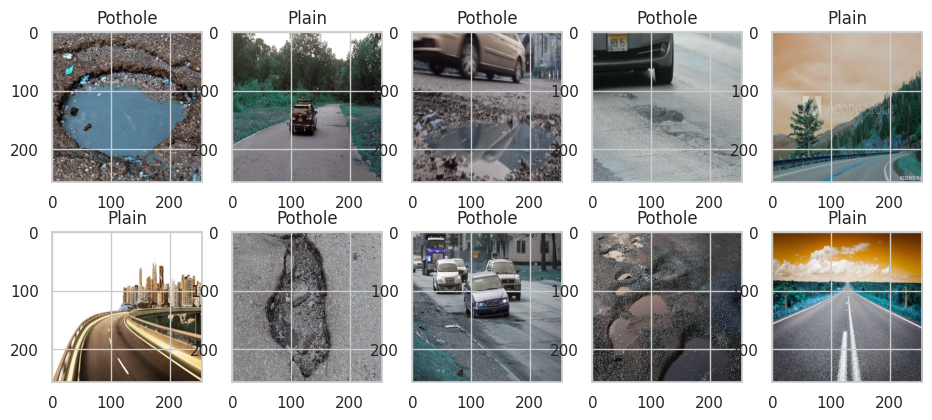

In [13]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

## Splitting the data into Training and Validation data

In [14]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Building the CNN model using RESNET (pretrained model)

In [15]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [17]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30408066 (116.00 MB)
Trainable params: 303

In [18]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
16/16 [==============================] - 58s 966ms/step - loss: 11.9109 - accuracy: 0.6804 - val_loss: 297975.9688 - val_accuracy: 0.5353
Epoch 2/50
16/16 [==============================] - 6s 397ms/step - loss: 0.8604 - accuracy: 0.8843 - val_loss: 79463544.0000 - val_accuracy: 0.5353
Epoch 3/50
16/16 [==============================] - 6s 405ms/step - loss: 0.2598 - accuracy: 0.9176 - val_loss: 23785988.0000 - val_accuracy: 0.5353
Epoch 4/50
16/16 [==============================] - 6s 404ms/step - loss: 0.1691 - accuracy: 0.9431 - val_loss: 2184335.7500 - val_accuracy: 0.5353
Epoch 5/50
16/16 [==============================] - 7s 423ms/step - loss: 1.3220 - accuracy: 0.9196 - val_loss: 2379513.5000 - val_accuracy: 0.5353
Epoch 6/50
16/16 [==============================] - 7s 420ms/step - loss: 0.2982 - accuracy: 0.8961 - val_loss: 197487.4531 - val_accuracy: 0.5353
Epoch 7/50
16/16 [==============================] - 7s 412ms/step - loss: 0.2666 - accuracy: 0.8980 - val_loss

## Saving the trained model

In [21]:
model.save('/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/model1.h5')


## Model Accuracy

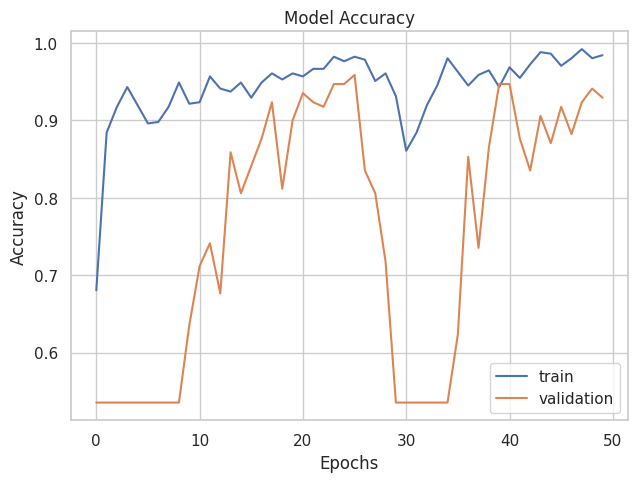

In [22]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Model Loss

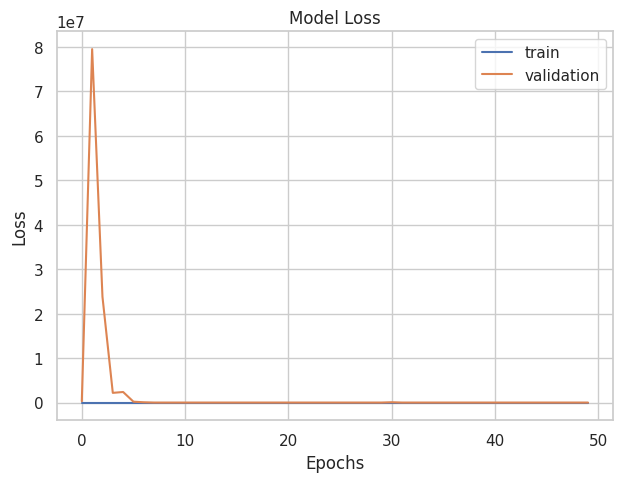

In [23]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Testing the trained model
### [0,1] --> Pothole road
### [1,0] --> Plain road

### Testing the trained model on Pothole images

In [25]:
path = "/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Colab Notebooks (1)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/dataset/test_pot_images"
files = os.listdir(path)
files

['157.jpg', '305.jpg', '20.jpg', '49.jpg', '325.jpg', '74.jpg']

  0%|          | 0/6 [00:00<?, ?it/s]

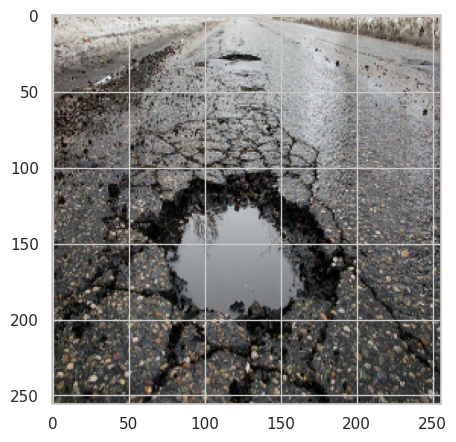

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 1/6 [00:03<00:19,  3.88s/it]

Pothole Road


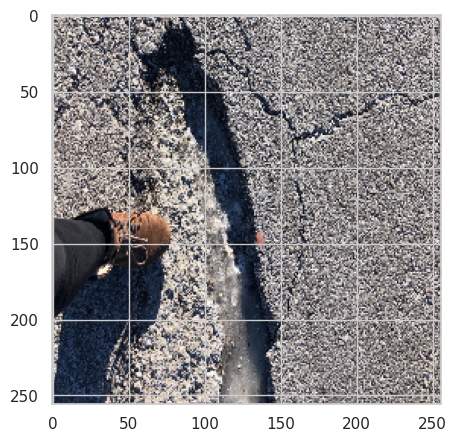

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2/6 [00:05<00:09,  2.26s/it]

Pothole Road


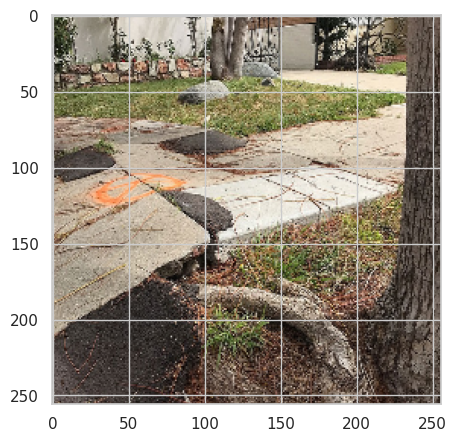

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 3/6 [00:06<00:05,  1.73s/it]

Plain Road


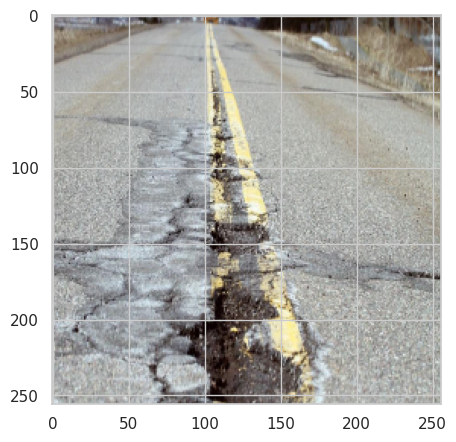

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4/6 [00:07<00:03,  1.52s/it]

Pothole Road


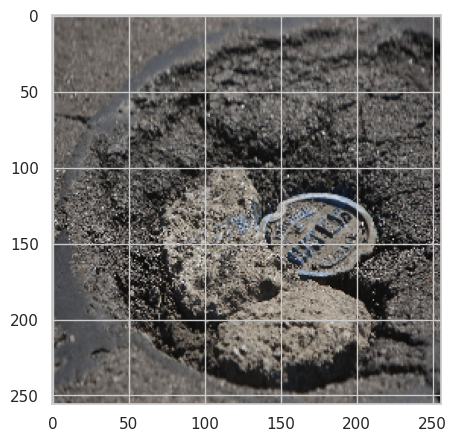

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5/6 [00:08<00:01,  1.45s/it]

Pothole Road


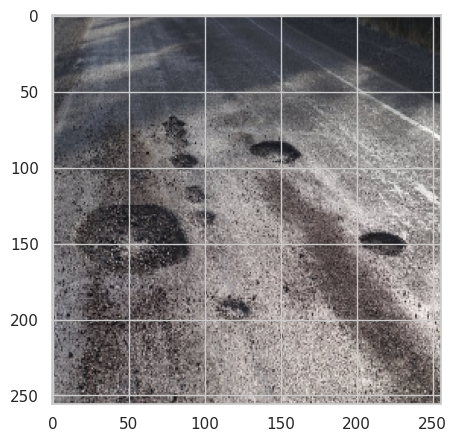

1/1 [==============================] - 0s 40ms/step


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]

Pothole Road


In [26]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1])
    plt.show()

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

### Testing the trained model on Plain images

In [28]:
path = "/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Colab Notebooks (1)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/dataset/test_norm_images"
files = os.listdir(path)
files

['323.jpg', '15.jpg', '37.jpg', '328.jpg', '71.jpg', '264.jpg']

  0%|          | 0/6 [00:00<?, ?it/s]

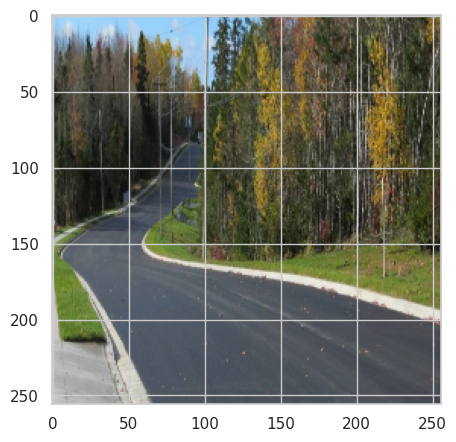

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]

Plain Road


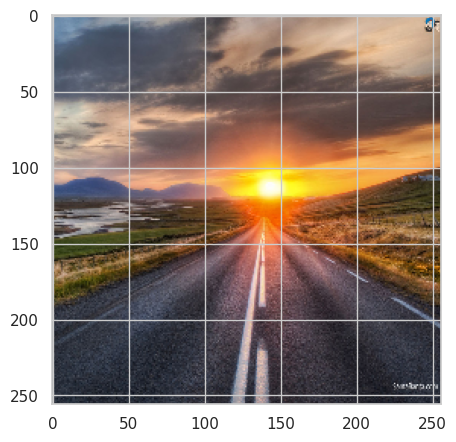

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]

Plain Road


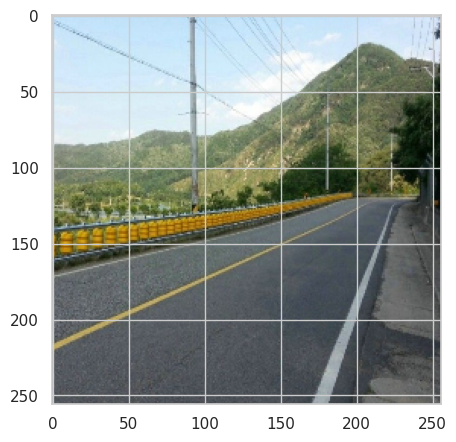

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3/6 [00:02<00:02,  1.09it/s]

Plain Road


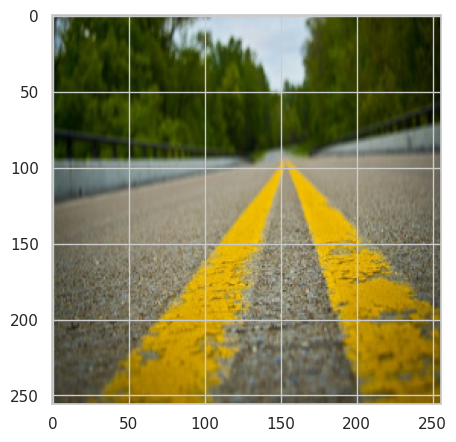

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4/6 [00:03<00:01,  1.13it/s]

Plain Road


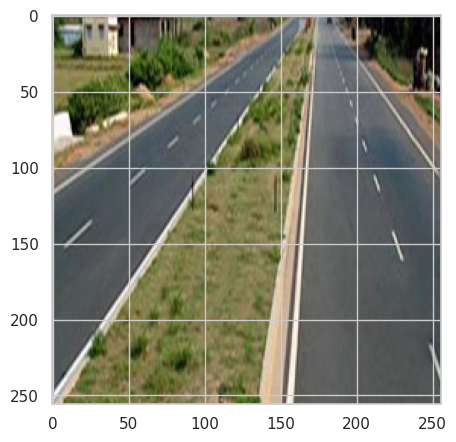

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5/6 [00:04<00:00,  1.18it/s]

Plain Road


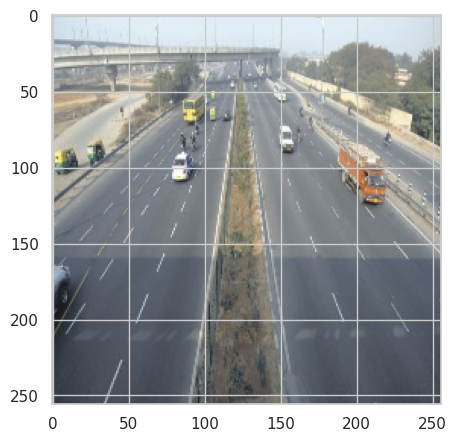

1/1 [==============================] - 0s 39ms/step


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

Plain Road


In [29]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1])
    plt.show()

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

### Loading the model

In [30]:
History = tf.keras.models.load_model('/content/drive/MyDrive/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/Pot Hole Detection on the roads using Transfer Learning (Resnet 50)/model1.h5')

In [31]:
score, acc = History.evaluate(x_test, y_test)
score, acc

6/6 [==============================] - 2s 99ms/step - loss: 0.2158 - accuracy: 0.9294


(0.2157822847366333, 0.929411768913269)